In [68]:
import pandas as pd
import numpy as np
import matplotlib as mp
import sklearn as sk
import tensorflow as tf
from tensorflow import keras


In [69]:
df = pd.read_csv('recommendations.csv', usecols = ['app_id', 'is_recommended','hours','user_id'])

In [70]:
df.isnull().sum()

app_id            0
is_recommended    0
hours             0
user_id           0
dtype: int64

In [71]:
df = df.drop_duplicates()

In [72]:
unique_game_count = df['app_id'].nunique()
unique_user_count = df['user_id'].nunique()
print(f"Number of unique games : {unique_game_count}")
print(f"Number of unique users : {unique_user_count}")


Number of unique games : 37610
Number of unique users : 13781059


There seems to be to many games and users, since this is about building a recommender system. I want to manually select some popular games. The rule of thumb for popularity is set to be at least recommended by 1000 users. Next cell implemented this in code. 

In [73]:
import pandas as pd

# Assuming your DataFrame is named df

# Filter the dataset to only include rows where 'is_recommended' is True
recommended_df = df[df['is_recommended'] == True]

# Group by 'app_id' and count the number of times 'is_recommended' is True
app_recommend_count = recommended_df.groupby('app_id').size()

# Filter to get only those 'app_id' with at least 1000 recommendations
apps_with_min_recommend = app_recommend_count[app_recommend_count >= 1000].index

# Filter the original DataFrame to include only the selected 'app_id'
tailored_df = df[df['app_id'].isin(apps_with_min_recommend)]

# Display the tailored DataFrame
tailored_df.head


<bound method NDFrame.head of            app_id  is_recommended  hours   user_id
0          975370            True   36.3     51580
1          304390           False   11.5      2586
2         1085660            True  336.5    253880
3          703080            True   27.4    259432
4          526870            True    7.9     23869
...           ...             ...    ...       ...
41154789   633230            True   41.0   1606890
41154790   758870           False    8.0   1786254
41154791   696170           False    2.0   6370324
41154792   696170            True    4.0   1044289
41154793  1089980            True   14.0  13971935

[37103573 rows x 4 columns]>

In [74]:
unique_game_count = tailored_df['app_id'].nunique()
print(f"Number of unique games : {unique_game_count}")

Number of unique games : 3262


There's also too many users, I will select the top 100000 active users who like to give reviews to train my model.

In [75]:
# Count the number of occurrences of each user_id
user_review_counts = tailored_df['user_id'].value_counts()

# Get the top 100,000 most active users
top_users = user_review_counts.head(100000).index

# Filter the original DataFrame to include only the top 100,000 active users
df_top_users = tailored_df[tailored_df['user_id'].isin(top_users)]

# Display the filtered DataFrame
df_top_users.head()


,app_id,is_recommended,hours,user_id
22,534380,True,40.6,22793
32,438100,True,8.1,912612
58,602960,True,41.9,737481
130,105600,True,528.3,4470638
138,570940,False,73.3,5136277


In [76]:
unique_game_count = df_top_users['app_id'].nunique()
unique_user_count = df_top_users['user_id'].nunique()
print(f"Number of unique games : {unique_game_count}")
print(f"Number of unique users : {unique_user_count}")

Number of unique games : 3262
Number of unique users : 100000


'is_recommended' column provides a basic guideline for whether a user like a game or not. But it's not suffice to describe how much she likes it. Thus, we analyze the 'hours' column. In short, the longer a user spent in game, the more convincible for her review, and the more she likes the game. 

In [77]:
import pandas as pd

# Define the function that takes 'is_recommended' and 'hours' and returns a 'rating'
def calculate_rating(is_recommended, hours):
    # The hours played an user spent in an hour affects user's 'qualification' to judge the game, the longer he/she played, more convincible he/she recommends the game or not.
    if is_recommended == True:
        if hours >= 100:
            rating = 10.0 # User really love the game, so 10.0
        else:
            rating = 5 + hours/20
            rating = round(rating,1) # rounded to the nearest 0.1
    else:
        rating = 5 - hours/20
        rating = max(rating,0)
        rating = round(rating,1)  # If the user spends long time in a game but still does not recommended it, then he/she must really not like the game. 
    return rating

# Apply the function to each row and create a new column 'rating'
df_top_users['rating'] = df_top_users.apply(lambda row: calculate_rating(row['is_recommended'], row['hours']), axis=1)

# Display the DataFrame to verify the new 'rating' column
df_top_users.head()


/var/folders/0x/8p42fct94xg0v77sv5bj7j8r0000gn/T/ipykernel_838/1729956827.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_users['rating'] = df_top_users.apply(lambda row: calculate_rating(row['is_recommended'], row['hours']), axis=1)


,app_id,is_recommended,hours,user_id,rating
22,534380,True,40.6,22793,7.0
32,438100,True,8.1,912612,5.4
58,602960,True,41.9,737481,7.1
130,105600,True,528.3,4470638,10.0
138,570940,False,73.3,5136277,1.3


In [78]:
rating_df = df_top_users.drop(columns=['is_recommended','hours'])
rating_df.head()

,app_id,user_id,rating
22,534380,22793,7.0
32,438100,912612,5.4
58,602960,737481,7.1
130,105600,4470638,10.0
138,570940,5136277,1.3


In [79]:
# Drop duplicate entries, keeping the first occurrence
df_unique = rating_df.drop_duplicates(subset=['user_id', 'app_id'])

# Pivot the unique DataFrame
pivot_df = df_unique.pivot(index='user_id', columns='app_id', values='rating')

# Display the reshaped DataFrame
pivot_df.shape


(100000, 3262)

Re-shaping the dataset.

In [80]:
pivot_df.head()

app_id,10,20,30,40,50,60,70,80,130,220,...,2059790,2060130,2064650,2066020,2067920,2073470,2087030,2088250,2088570,2208920
user_id,,,,,,,,,,,,,,,,,,,,,
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Re-index the dataset to make it looks good to read.

In [81]:
# Create a mapping for user_id
user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(pivot_df.index, start=1)}
pivot_df.index = pivot_df.index.map(user_id_mapping)

# Create a mapping for app_id (column names)
app_id_mapping = {old_id: new_id for new_id, old_id in enumerate(pivot_df.columns, start=1)}
pivot_df.columns = pivot_df.columns.map(app_id_mapping)

# Display the re-indexed DataFrame
pivot_df.head()


app_id,1,2,3,4,5,6,7,8,9,10,...,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Splitting the dataset for training and testing.

In [82]:
# Select the top 80,000 rows for training
train_data = pivot_df.iloc[:80000]

# Select the remaining rows for testing
test_data = pivot_df.iloc[80000:]

# Display the shapes to verify
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Optionally, display the first few rows of each set
train_data.head(), test_data.head()


Training data shape: (80000, 3262)
Testing data shape: (20000, 3262)


(app_id   1     2     3     4     5     6     7     8     9     10    ...  \
 user_id                                                              ...   
 1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
 2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
 3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
 4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.1  ...   
 5         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
 
 app_id   3253  3254  3255  3256  3257  3258  3259  3260  3261  3262  
 user_id                                                              
 1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 5         NaN   NaN   NaN   NaN 

In [83]:
R = train_data.notnull().astype(int)
R = R.T
R.shape

(3262, 80000)

In [84]:
train_data = train_data.fillna(0)
train_data = train_data.T

In [85]:
game_features = np.zeros((3262,100))
user_features = np.zeros((80000,100))
user_bias = np.zeros((1,80000))

Next, define the cost function used for training. compute_cost_func and cofi_cost_func have the same functionality. compute_cost_func is more easy to read and understand while cofi_cost_func is computationally faster. I included regularization terms to prevent overfitting.

In [86]:

def compute_cost_func(game_features, user_features, user_bias, train_data, R, lambda_):
   
    nm, nu = train_data.shape
    J = 0
    ### START CODE HERE ###  
    for i in range (nm):
        for j in range(nu):
            if(R[i][j]==1):
                J+=np.square(np.dot(user_features[j,:],game_features[i])+user_bias[0,j]-train_data[i][j])
    n=game_features.shape[1]
    reg1=0
    for j in range(nu):
        for k in range (n):
            reg1 += (user_features[j][k])**2
    reg2=0
    for i in range(nm):
        for k in range (n):
            reg2 += (game_features[i][k])**2
    reg=(reg1+reg2)*lambda_
    J+=reg
    J=J/2
    ### END CODE HERE ### 

    return J

In [87]:
def cofi_cost_func(game_features, user_features, user_bias, train_data, R, lambda_):
    j = (tf.linalg.matmul(game_features, tf.transpose(user_features)) + user_bias - train_data)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(game_features**2) + tf.reduce_sum(user_features**2))
    return J

Prepare for training，set 100 hidden features for both user and game. The training process will fill up those parameters for features.

In [88]:
num_games, num_users = train_data.shape
num_features = 100
tf.random.set_seed(1234) # for consistent results
user_features = tf.Variable(tf.random.normal((num_users,  num_features),dtype=tf.float64),  name='user_features')
game_features = tf.Variable(tf.random.normal((num_games, num_features),dtype=tf.float64),  name='game_features')
user_bias = tf.Variable(tf.random.normal((1,          num_users),   dtype=tf.float64),  name='user_bias')
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

Record the training loss. At this part, I made an coding error, so the loss at the first 100 iterations is lost. I have printed out myself to see that the initial loss at iteration 1 is roughly 2 * 10^9. The loss drops very quickly at the beginning, the data below is already trained for 100 iterations. But the shape of the loss function should be the same. 

In [103]:
loss = []

In [116]:
iterations = 174
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost 
    with tf.GradientTape() as tape:

        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func(game_features, user_features, user_bias, train_data, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(cost_value, [game_features,user_features,user_bias] )

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients( zip(grads, [game_features,user_features,user_bias]) )

    # Log periodically.
    loss.append(cost_value)

In [127]:
print(loss[0])
print(loss[-1])

tf.Tensor(2834753.176508111, shape=(), dtype=float64)
tf.Tensor(264223.67615223024, shape=(), dtype=float64)


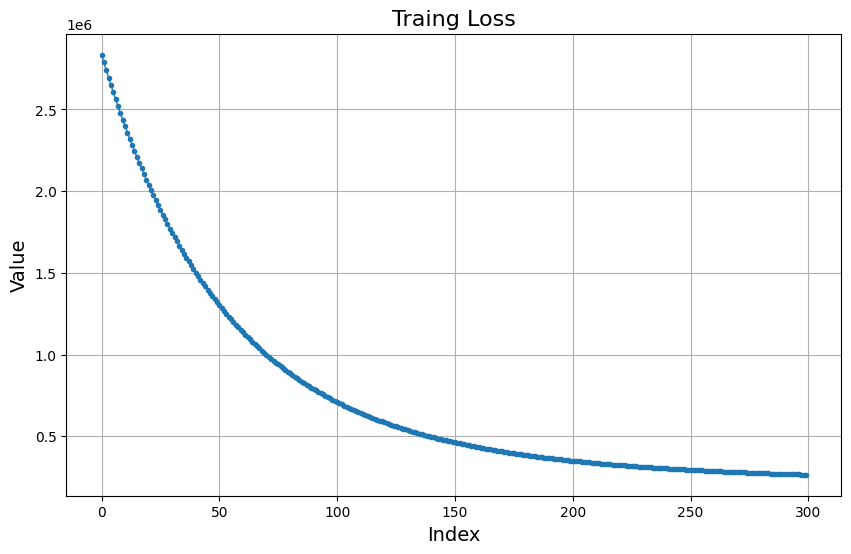

In [125]:
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(loss, marker='o', markersize=3, linestyle='-', linewidth=1)

# Add titles and labels
plt.title('Traing Loss', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Optional: Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()


Compute the predictions for each user by our algorithm.

In [118]:
predictions = np.matmul(game_features.numpy(), np.transpose(user_features.numpy())) + user_bias.numpy()
predictions_clipped = np.clip(predictions, 0.0, 10.0)
predictions_df = pd.DataFrame(
    predictions_clipped,
    index=[f"app_{i}" for i in range(predictions_clipped.shape[0])],  # User IDs as row labels
    columns=[f"user_{j}" for j in range(predictions_clipped.shape[1])]  # Feature names as column labels)
)


In [133]:
def compare_ratings(user_id):
    """
    Compare actual ratings from train_data and predicted ratings from predictions_df for a given user column index.
    
    Args:
        user_id (int): The column index of the user in train_data and predictions_df.

    
    Returns:
        [actual_ratings, predicted_ratings]
    """
    # Check if the user_id is a valid column index
    if user_id >= train_data.shape[1]:
        print(f"User column index {user_id} is out of range.")
        return

    # Get the column name for the given user index
    user_column = train_data.columns[user_id]
    
    # Get actual ratings for the user from train_data
    actual_ratings = train_data.iloc[:, user_id]
    
    # Get predicted ratings for the user from predictions_df
    predicted_ratings = predictions_df.iloc[:, user_id]
    
    # Find indices of items the user has rated (non-zero entries)
    rated_items = actual_ratings[actual_ratings != 0].index
    
    # Print out comparisons
    print(f"Comparisons for User {user_id}")
    for item in rated_items:
        actual = actual_ratings[item]
        predicted = predicted_ratings[item]
        print(f"  Item {item}: Actual Rating= {actual}, Predicted Rating= {round(predicted, 1)}")
    return actual_ratings, predicted_ratings


Comparisons for User 69604
  Item 62: Actual Rating= 5.2, Predicted Rating= 3.8
  Item 64: Actual Rating= 6.0, Predicted Rating= 5.0
  Item 113: Actual Rating= 6.0, Predicted Rating= 3.3
  Item 125: Actual Rating= 5.1, Predicted Rating= 6.2
  Item 144: Actual Rating= 4.8, Predicted Rating= 5.3
  Item 164: Actual Rating= 5.2, Predicted Rating= 4.1
  Item 209: Actual Rating= 5.4, Predicted Rating= 4.9
  Item 221: Actual Rating= 5.1, Predicted Rating= 4.9
  Item 273: Actual Rating= 7.6, Predicted Rating= 5.5
  Item 283: Actual Rating= 5.2, Predicted Rating= 5.9
  Item 289: Actual Rating= 5.1, Predicted Rating= 4.8
  Item 373: Actual Rating= 5.2, Predicted Rating= 4.4
  Item 387: Actual Rating= 5.2, Predicted Rating= 5.4
  Item 419: Actual Rating= 6.7, Predicted Rating= 5.2
  Item 559: Actual Rating= 5.0, Predicted Rating= 5.2
  Item 612: Actual Rating= 5.1, Predicted Rating= 4.6
  Item 687: Actual Rating= 7.1, Predicted Rating= 4.4
  Item 710: Actual Rating= 6.2, Predicted Rating= 5.1
  I

/var/folders/0x/8p42fct94xg0v77sv5bj7j8r0000gn/T/ipykernel_838/1663727430.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted = predicted_ratings[item]
/var/folders/0x/8p42fct94xg0v77sv5bj7j8r0000gn/T/ipykernel_838/15264256.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_ratings = predicted_ratings[rated_items]


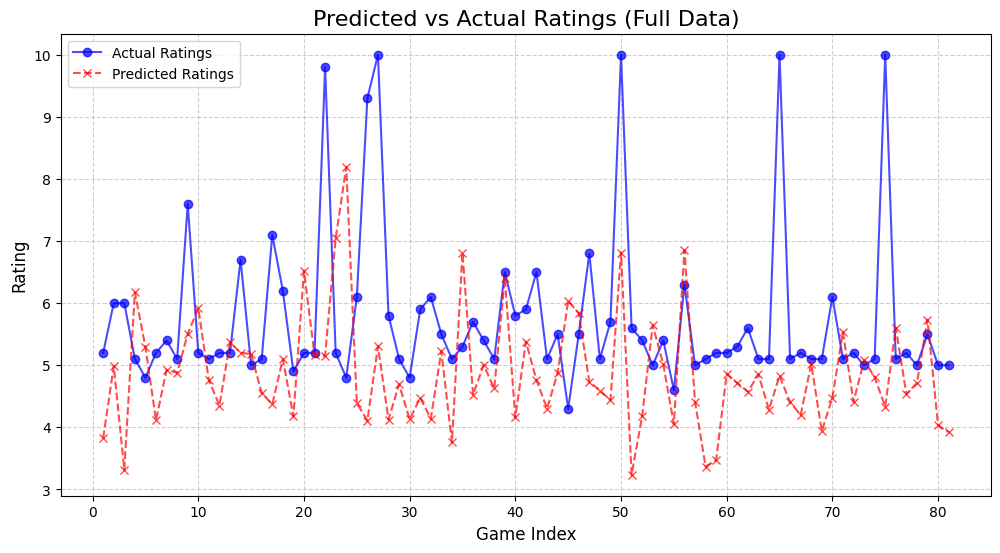

In [139]:
import random
import matplotlib.pyplot as plt
import numpy as np
# Sample data (replace these with your actual data)
actual_ratings, predicted_ratings = compare_ratings(random.randint(1, 80000))
rated_items = actual_ratings[actual_ratings != 0].index
a_ratings = actual_ratings[rated_items]
p_ratings = predicted_ratings[rated_items]
game_indices = range(1, len(p_ratings) + 1)

# Plot full data with transparency
plt.figure(figsize=(12, 6))
plt.plot(game_indices, a_ratings, label='Actual Ratings', color='blue', alpha=0.7, marker='o', linestyle='-')
plt.plot(game_indices, p_ratings, label='Predicted Ratings', color='red', alpha=0.7, marker='x', linestyle='--')

# Customization
plt.xlabel('Game Index', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title('Predicted vs Actual Ratings (Full Data)', fontsize=16)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




In [131]:
def recommend_top_unrated_items(user_id, top_n=10):
    """
    Recommend the top N items with the highest predicted ratings for a given user
    that have not been actually rated by the user (i.e., value in train_df is 0).

    Parameters:
    - user_id (str): The ID of the user (e.g., 'user_0').
    - top_n (int): The number of top items to recommend (default is 10).

    Returns:
    - pd.Series: A series containing the top N items and their predicted ratings for the given user.
    """
    if user_id not in predictions_df.columns or user_id not in train_df.columns:
        raise ValueError(f"User ID {user_id} not found in predictions or train DataFrame.")
    
    # Get the predicted ratings and actual ratings for the given user
    predicted_ratings = predictions_df.iloc[:, user_id]
    actual_ratings = train_df[:, user_id]
    
    # Filter items that are not rated by the user (actual rating == 0)
    unrated_items = actual_ratings[actual_ratings == 0].index
    predicted_unrated = predicted_ratings.loc[unrated_items]
    
    # Sort the predictions for unrated items in descending order and get the top N
    top_items = predicted_unrated.sort_values(ascending=False).head(top_n)
    
    return top_items



    


In [132]:
import random
recommend_top_items(random.randint(1,80000))


Top 10 recommendations for User 7982:
app_1311    10.0
app_2557    10.0
app_512     10.0
app_1129    10.0
app_2905    10.0
app_2154    10.0
app_315     10.0
app_1243    10.0
app_1654    10.0
app_655     10.0
Name: user_7982, dtype: float64


app_1311    10.0
app_2557    10.0
app_512     10.0
app_1129    10.0
app_2905    10.0
app_2154    10.0
app_315     10.0
app_1243    10.0
app_1654    10.0
app_655     10.0
Name: user_7982, dtype: float64